Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /home/bli/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /home/bli/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


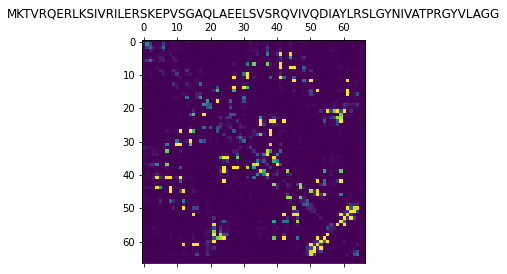

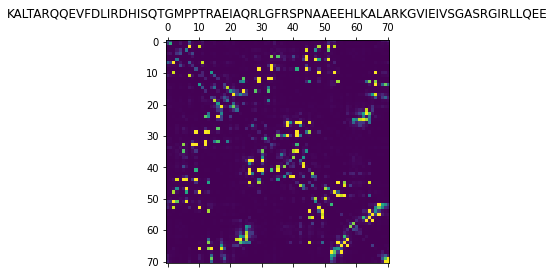

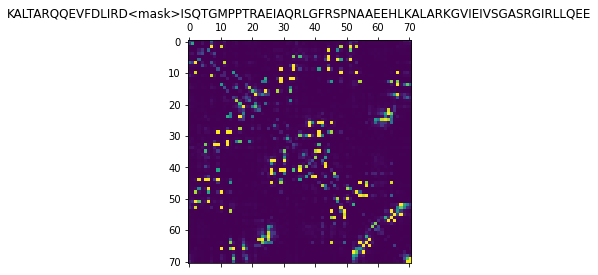

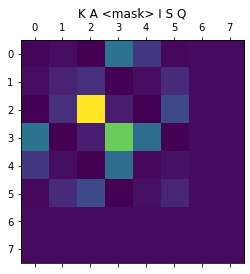

In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [2]:
DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMB_PRE_PATH = "/home/bli/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt" 
EMBED_PATH =DATA_PATH+'/ESM2_15b_embed/'
EMB_LAYER = 33

In [3]:
import pathlib
import pandas as pd
import torch

from esm import Alphabet, FastaBatchedDataset, ProteinBertModel, pretrained, MSATransformer


import os

class ProteinExtractionParams:
    def __init__(
        self,
        model_location=EMB_PRE_PATH,
        fasta_file = None,
        csv_file = None,
        output_dir = None,
        toks_per_batch=4096,
        repr_layers=[-1],
        include='mean',
        truncation_seq_length=512,
        nogpu=False,
    ):
        self.model_location = model_location
        self.fasta_file = fasta_file
        self.csv_file = csv_file

        self.output_dir = pathlib.Path(output_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        self.toks_per_batch = toks_per_batch
        self.repr_layers = repr_layers
        self.include = include
        self.truncation_seq_length = truncation_seq_length
        self.nogpu = nogpu


def run(args):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    model.eval()
    if isinstance(model, MSATransformer):
        raise ValueError(
            "This script currently does not handle models with MSA input (MSA Transformer)."
        )
    if torch.cuda.is_available() and not args.nogpu:
        model = model.cuda()
        print("Transferred model to GPU")


    if(args.fasta_file):
        dataset = FastaBatchedDataset.from_file(args.fasta_file)
        batches = dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
        data_loader = torch.utils.data.DataLoader(
            dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=batches
        )
        print(f"Read {args.fasta_file} with {len(dataset)} sequences")
    elif(args.csv_file):
        data_df = pd.read_csv(args.csv_file)
        
        protein_id = data_df['id']
        # class FastaBatchedDataset(object):
        #     def __init__(self, sequence_labels, sequence_strs):
        #         self.sequence_labels = list(sequence_labels)
        #         self.sequence_strs = list(sequence_strs)
        dataset = FastaBatchedDataset(data_df['id'],data_df['seq'])
        batches = dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
        data_loader = torch.utils.data.DataLoader(
            dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=batches
        )
        print(f"Read {args.csv_file} with {len(dataset)} sequences")
    else:
        print('no file!')

    args.output_dir.mkdir(parents=True, exist_ok=True)
    return_contacts = "contacts" in args.include                                                                                                                                

    assert all(-(model.num_layers + 1) <= i <= model.num_layers for i in args.repr_layers)
    repr_layers = [(i + model.num_layers + 1) % (model.num_layers + 1) for i in args.repr_layers]

    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_loader):
            print(
                f"Processing {batch_idx + 1} of {len(batches)} batches ({toks.size(0)} sequences)"
            )
            if torch.cuda.is_available() and not args.nogpu:
                toks = toks.to(device="cuda", non_blocking=True)

            out = model(toks, repr_layers=repr_layers, return_contacts=return_contacts)

            logits = out["logits"].to(device="cpu")
            representations = {
                layer: t.to(device="cpu") for layer, t in out["representations"].items()
            }
            if return_contacts:
                contacts = out["contacts"].to(device="cpu")

            for i, label in enumerate(labels):
                args.output_file = args.output_dir / f"{label}.pt"
                args.output_file.parent.mkdir(parents=True, exist_ok=True)
                result = {"label": label}
                truncate_len = min(args.truncation_seq_length, len(strs[i]))
                # Call clone on tensors to ensure tensors are not views into a larger representation
                # See https://github.com/pytorch/pytorch/issues/1995
                if "per_tok" in args.include:
                    result["representations"] = {
                        layer: t[i, 1 : truncate_len + 1].clone()
                        for layer, t in representations.items()
                    }
                if "mean" in args.include:
                    result["mean_representations"] = {
                        layer: t[i, 1 : truncate_len + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }
                if "bos" in args.include:
                    result["bos_representations"] = {
                        layer: t[i, 0].clone() for layer, t in representations.items()
                    }
                if return_contacts:
                    result["contacts"] = contacts[i, : truncate_len, : truncate_len].clone()

                torch.save(
                    result,
                    args.output_file,
                )


In [4]:
def extract_embed(data_file):
    input_data  =DATA_PATH+data_file
    output_dir = EMBED_PATH+data_file.split('.')[0]
    args = ProteinExtractionParams(csv_file=input_data,output_dir=output_dir)
    run(args)
    print('Extract ESM2_15b embeddings for {}, save in {}'.format(input_data,output_dir))

In [5]:
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        print(file)
        extract_embed(file)

test_data1_2023-6-9_15_31.csv


Transferred model to GPU
Read ../dataset/dataset2.0/test_data1_2023-6-9_15_31.csv with 226 sequences
Processing 1 of 21 batches (30 sequences)
Processing 2 of 21 batches (21 sequences)
Processing 3 of 21 batches (18 sequences)
Processing 4 of 21 batches (16 sequences)
Processing 5 of 21 batches (15 sequences)
Processing 6 of 21 batches (13 sequences)
Processing 7 of 21 batches (12 sequences)
Processing 8 of 21 batches (11 sequences)
Processing 9 of 21 batches (10 sequences)
Processing 10 of 21 batches (9 sequences)
Processing 11 of 21 batches (9 sequences)
Processing 12 of 21 batches (8 sequences)
Processing 13 of 21 batches (8 sequences)
Processing 14 of 21 batches (7 sequences)
Processing 15 of 21 batches (7 sequences)
Processing 16 of 21 batches (7 sequences)
Processing 17 of 21 batches (6 sequences)
Processing 18 of 21 batches (6 sequences)
Processing 19 of 21 batches (6 sequences)
Processing 20 of 21 batches (5 sequences)
Processing 21 of 21 batches (2 sequences)
Extract ESM2_15b 

In [6]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
def load_esm_embed(csv_file):
    Xs = []
    ys = []
    Embed_PATH = EMBED_PATH+csv_file.split('.')[0]
    data_df =  pd.read_csv(DATA_PATH+csv_file)
    for index, row in data_df.iterrows():
        id = row['id']
        label = row['label']

        fn = f'{Embed_PATH}/{id}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])
        ys.append(label)
    Xs = torch.stack(Xs, dim=0).numpy()
    print('load{} esm embedding'.format(csv_file))
    print(len(ys))
    print(Xs.shape)
    return Xs,ys
Xs = []
ys = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        if file.endswith('llpsdb_d.csv'):continue
        x,y = load_esm_embed(file)
        Xs.append(x)
        ys.append(y)
Xs = np.vstack((*Xs,))
ys = [y for sub in ys for y in sub]
print(len(ys))
print(Xs.shape)
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

loadtest_data1_2023-6-9_15_31.csv esm embedding
226
(226, 1280)
loadtest_data2_2023-6-9_15_31.csv esm embedding
274
(274, 1280)
loadpositive_train_422.csv esm embedding
422
(422, 1280)
loadnegative_train_3307.csv esm embedding
3307
(3307, 1280)
4229
(4229, 1280)


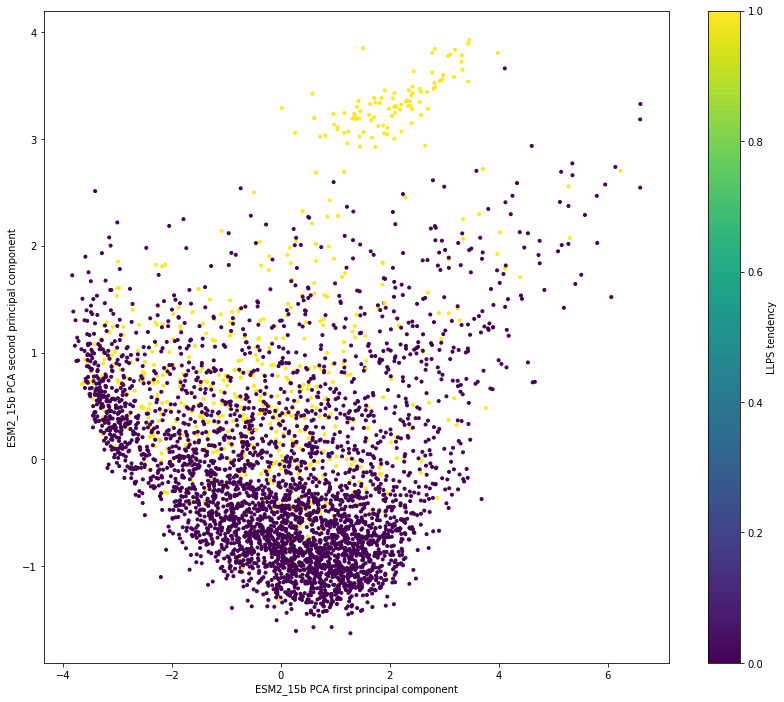

In [12]:
import matplotlib.pyplot as plt
fig_dims = (14, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=ys, marker='.')
ax.set_xlabel('ESM2_15b PCA first principal component')
ax.set_ylabel('ESM2_15b PCA second principal component')
plt.colorbar(sc, label='LLPS tendency')

/home/bli/.conda/envs/Xihe/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


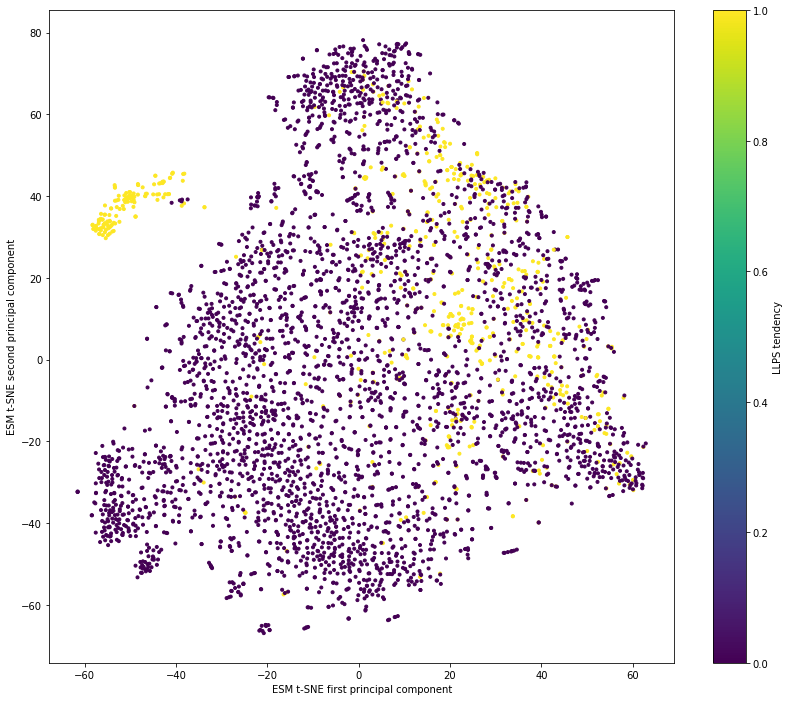

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_tsne = TSNE(learning_rate=200.0, n_components=2,perplexity=40, random_state=42).fit_transform(Xs)
fig_dims = (14, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=ys, marker='.')
ax.set_xlabel('ESM t-SNE first principal component')
ax.set_ylabel('ESM t-SNE second principal component')
plt.colorbar(sc, label='LLPS tendency')

/home/bli/.conda/envs/Xihe/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


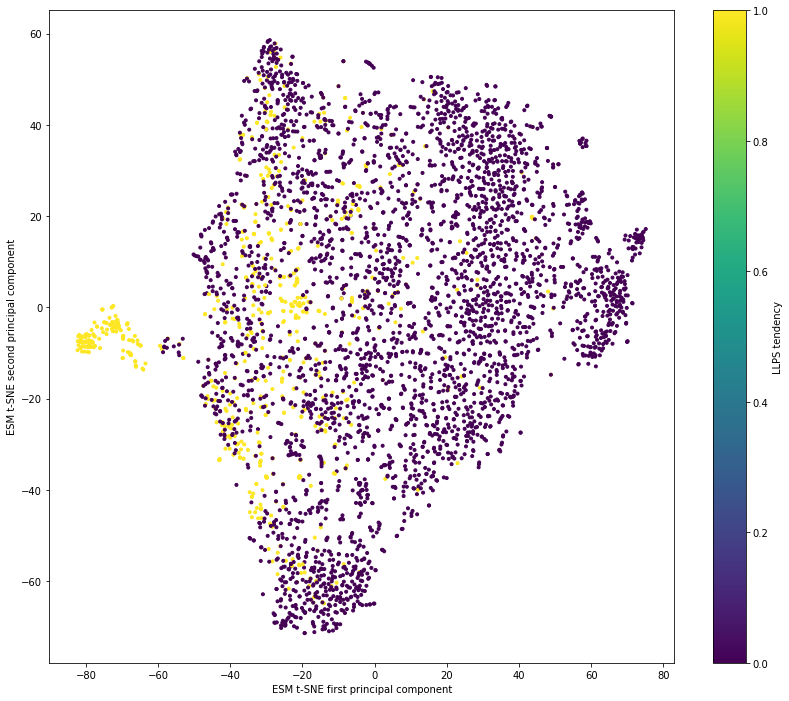

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_tsne = TSNE(learning_rate=200.0, n_components=2,perplexity=40, random_state=42).fit_transform(Xs_pca)
fig_dims = (14, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=ys, marker='.')
ax.set_xlabel('ESM t-SNE first principal component')
ax.set_ylabel('ESM t-SNE second principal component')
plt.colorbar(sc, label='LLPS tendency')